In [6]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from skimage import io, color, filters, measure
import pickle as pkl
import yaml

import sys
sys.path.insert(0, "/home/icb/alessandro.palma/environment/IMPA/IMPA/experiments/measure_metrics")
from compute_metrics import *

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from itertools import combinations

In [29]:
def initialize_model(yaml_config, dest_dir):
    args_rdkit = OmegaConf.create(yaml_config)
    dataloader_rdkit = CellDataLoader(args_rdkit)
    solver_rdkit = IMPAmodule(args_rdkit, dest_dir, dataloader_rdkit)
    return solver_rdkit

def transform_by_emb(solver, dataloader, y, n_average, args):
    """
    Transform images in a dataloader using a solver for a specific drug ID.

    Parameters:
        solver: The solver object used for transformation.
        dataloader: The dataloader containing images to be transformed.
        n_average (int): Number of times to average random noise vectors.
        drug_id (str): The ID of the drug for transformation.
        args: Arguments object containing additional parameters.

    Returns:
        tuple: A tuple containing two NumPy arrays representing controls and transformed images.
    """
    controls = []
    transformed = []
    y = y.unsqueeze(0)
    with torch.no_grad():
        for batch in tqdm(dataloader.train_dataloader()):
            X_ctr = batch["X"][0]
            z = torch.randn(X_ctr.shape[0], n_average, args.z_dimension).cuda().mean(1)
            # z = torch.randn(X_ctr.shape[0], n_average, args.z_dimension).cuda().quantile(0.75,0)
            
            # Perturbation ID 
            y_emb = y.repeat((z.shape[0], 1)).cuda()
            y_emb = torch.cat([y_emb, z], dim=1)
            y_emb = solver.nets.mapping_network(y_emb) 
            
            _, X_generated = solver.nets.generator(X_ctr, y_emb)
            transformed.append(t2np(X_generated.detach().cpu()))
            controls.append(t2np(X_ctr.detach().cpu()))
            break
    return np.concatenate(controls, axis=0), np.concatenate(transformed, axis=0)

def t2np(t, batch_dim=False):
    return ((t.permute(0, 2, 3, 1) + 1) / 2).clamp(0, 1).cpu().numpy()


def plot_n_images(images, n_to_plot, size=((1.5, 1.5))):
    for i, img in enumerate(images):
        plt.figure(figsize=size)
        plt.imshow(img)
        plt.show()
        if i == n_to_plot:
            break


**Collect drug embeddings**

In [11]:
# bbbbc021_embeddings = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/embeddings/csv/emb_rdkit.csv", index_col=0)
bbbbc021_embeddings = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/embeddings/csv/emb_fp.csv", index_col=0)

bbbc021_index = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv")
mol2moa = {mol:y for mol, y in zip(bbbc021_index["CPD_NAME"], bbbc021_index["ANNOT"])}

In [12]:
ood_drugs = ["colchicine"]

Initialize model

In [13]:
path_to_configs = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/config_hydra/config")

with open(path_to_configs / 'bbbc021_all_retrain_fp.yaml', 'r') as IMPA_bbbc021:
    # Load YAML data using safe_load() from the file
    yaml_IMPA_bbbc021 = yaml.safe_load(IMPA_bbbc021)
    yaml_IMPA_bbbc021["z_dimension"] = 64
    yaml_IMPA_bbbc021["style_dim"] = 128

dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240227_7992016c-be41-4c0f-921f-94835a5f1b33_bbbc021_all_retrain_fp_colchicine"

args = OmegaConf.create(yaml_IMPA_bbbc021)
dataloader = CellDataLoader(args)
IMPA_bbbc021 = initialize_model(yaml_IMPA_bbbc021, dest_dir)

IMPA_bbbc021._load_checkpoint(150)

Number of parameters in generator: 24752771
Number of parameters in style_encoder: 14362304
Number of parameters in discriminator: 14309465
Number of parameters in mapping_network: 139392
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): Embedding(25, 1024)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Fal

## Experiment 1: transform into unseen

In [24]:
for drug in ood_drugs:
    emb_drug = torch.Tensor(ood_drug_embeddings.loc[drug])
    controls, transformed = transform_by_emb(IMPA_bbbc021, dataloader, emb_drug, 100, args)

  0%|          | 0/194 [00:03<?, ?it/s]


In [28]:
controls.shap

(32, 96, 96, 3)

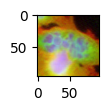

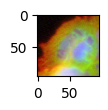

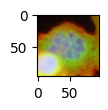

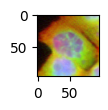

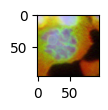

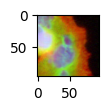

In [31]:
plot_n_images(transformed, 5, (0.8,0.8))

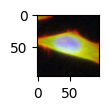

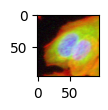

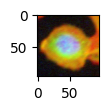

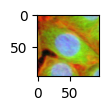

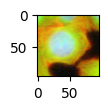

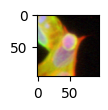

In [33]:
plot_n_images(controls, 5, (0.8,0.8))

**Check real images**

In [59]:
path_to_images = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all")

metadata = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv")

In [63]:
metadata = metadata.loc[metadata.CPD_NAME=="demecolcine"]

In [64]:
real_colchicine_images = []
for sample_key in metadata.SAMPLE_KEY:
    week, plate, im1, im2, im3 = sample_key.split("_")
    real_colchicine_images.append(np.load(path_to_images/ week / plate / f"{im1}_{im2}_{im3}.npy"))

In [65]:
real_colchicine_images =  np.stack(real_colchicine_images, axis=0)

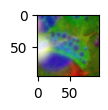

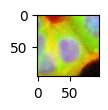

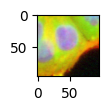

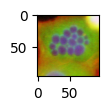

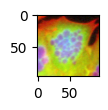

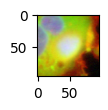

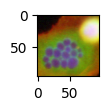

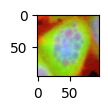

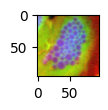

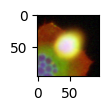

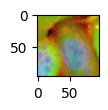

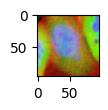

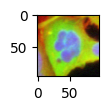

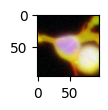

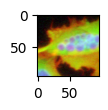

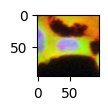

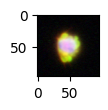

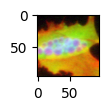

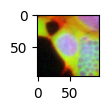

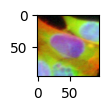

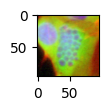

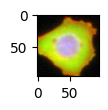

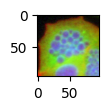

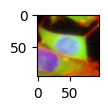

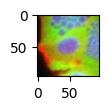

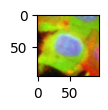

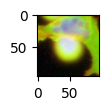

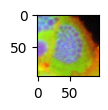

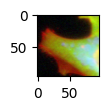

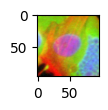

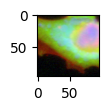

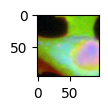

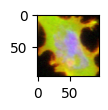

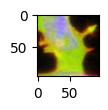

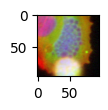

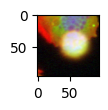

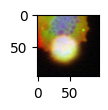

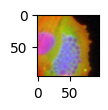

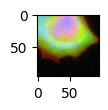

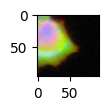

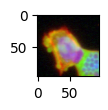

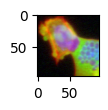

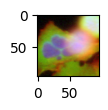

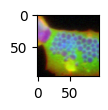

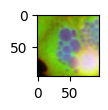

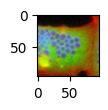

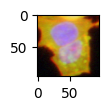

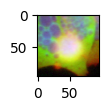

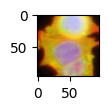

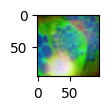

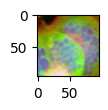

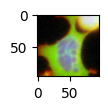

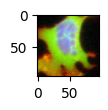

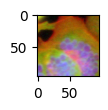

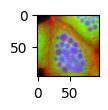

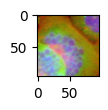

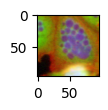

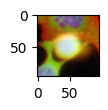

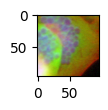

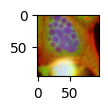

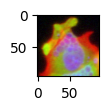

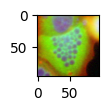

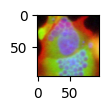

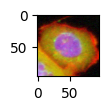

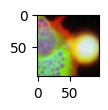

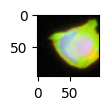

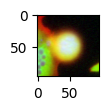

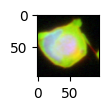

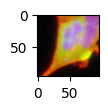

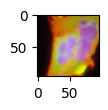

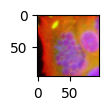

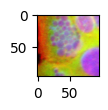

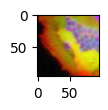

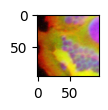

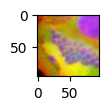

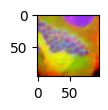

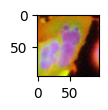

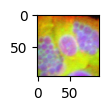

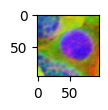

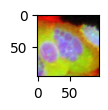

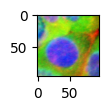

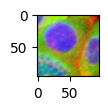

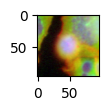

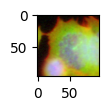

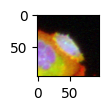

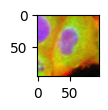

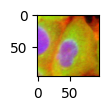

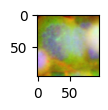

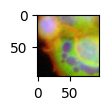

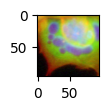

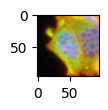

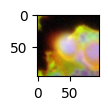

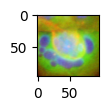

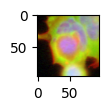

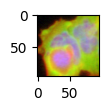

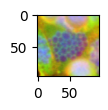

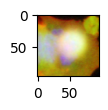

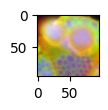

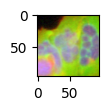

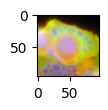

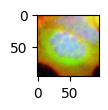

In [66]:
plot_n_images(real_colchicine_images, 100, (0.8,0.8))